<a href="https://colab.research.google.com/github/ezeiberg33/spinSynthFinal/blob/main/Final_Report_5971.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpinSynth: T1-to-T2 MRI Spin-Sequence Image Synthesis via GANs




**Authors and team:**
*   **Author** 1: Emily Zeiberg
*   **Author** 2: Katie Stubbs


# **Abstract**
Magnetic Resonance Imaging (MRI) is an important diagnostic tool in medicine, but its long acquisition time limits patient throughput, increases costs, and causes patient discomfort. In particular, the need to acquire both T1- and T2-weighted scans contributes to the extended scan durations. This project proposes a deep learning–based solution to synthesize T2-weighted images directly from T1-weighted scans using a conditional generative adversarial network (pix2pix). By using paired T1–T2 data from the IXI dataset, the model learns to preserve fine anatomical details, which are essential for clinical use. Preprocessing steps address alignment inconsistencies between sequentially captured scans and remove scanner-specific information encoded in the images. Model performance is evaluated using the Structural Similarity Index Measure (SSIM), emphasizing structural and contrast consistency to ensure diagnostic reliability. The potential benefits of this project include reduced MRI scan times, improved workflow eﬀiciency in hospitals, and reduced costs for healthcare systems, particularly in cases where sedation would normally be needed.

# **1. Executive Summary**

**Decisions to Be Impacted**

In hospital settings, the amount of time it takes to make a decision can greatly impact the patient’s outcome. By generating synthetic T2-weighted scans, doctors can be informed about their patient’s medical condition sooner, allowing the course of treatment to be determined and executed faster. The goal of this model is to reduce the average time that so that doctors have test results sooner and more scanner time can be available for patients with complex conditions. Additionally, this project would be helpful for determining if synthesized T2 images can be used as training data for future models, making the training process for MRI-based models faster and less costly.

**Business Value**

There are both business value and societal value with this model proposition. From the business side, we can see that for hospitals and imaging centers, generating T2 images from T1 scans streamlines workflow and reduces costs. MRI scanners are expensive and time-limited resources, and cutting out the need for multiple sequences increases effectiveness, allowing more patients to be seen each day. This efficiency translates into lower operating costs, fewer repeat scans, and less staff time spent managing lengthy procedures. Private centers gain a competitive edge by offering shorter, more comfortable exams, while pharmaceutical companies and research institutions benefit from faster and cheaper imaging during clinical trials. Overall, it’s a cost-saving, revenue-enhancing, and patient-attracting innovation.

For patients and the broader healthcare system, this technology reduces the burden of MRI scans by shortening exam times and minimizing the need for sedation or repeat procedures [1]. This is especially impactful for children, elderly individuals, and those with chronic neurological conditions who undergo frequent imaging. Faster scan times improve access in underserved areas by allowing more patients to be seen without additional machines, lowering wait times and broadening availability of high-quality imaging. At the population level, more efficient use of MRI resources means earlier diagnoses, improved disease monitoring, and ultimately better health outcomes [2].

It should be noted that while cost savings are somewhat minimal for everyday patients, patients who have a need to be under anesthesia will see a much larger impact. The reduction in a T2 scan, or approximately a difference in 3-6 minutes, can prevent sedation in somewhat difficult patients. Pediatric MRIs for example are approximately \$840 to have a sedated scan versus \$260 for a nonsedated scan [4]. This means that in these subgroups of patients, approximately \$580 can be saved on each person. So not only does the benefit of T2 generative images just improve MRI scheduling, but certain demographics are able to save hundreds on medical bills.



**Data Assets**

We used the IXI dataset, which consists of about 600 MRI scans from healthy patients. For each patient, T1 and T2 weighted scans were produced, so we can train the model on data where both the input and ground truth images are known. However, because the data for T1 and T2 scans was captured sequentially, there are some inconsistencies between corresponding images as a result of patient movement. As part of preprocessing steps, we used image registration techniques to make sure that the T1 and T2 images align as closely as possible. Additionally, this data was collected at three different hospitals using MRI machines with two different magnet strengths, so imaging effects from the scanner will have to be removed. This dataset is owned by the University College London, and it is free to use as long as we credit the original source [5]. An example of a T1-weighted and T2-weighted image pair from the dataset is shown below.

<img src='https://drive.google.com/uc?id=1thUL-4WVnpuzWzrBGsTrHnGjvzv9r4me' width="600" height="300">

# **2. Data Preprocessing**

**Coordinate System Transformation**

The first preprocessing step involved converting all images to be on the same coordinate system. The standard coordinate system for MRI scans is RAS, which means the positive x direction corresponds to the patient's right side, the positive y direction corresponds to the patient's anterior (front), and the positive z direction corresponds to the patient's superior (top). NiBabel, a library that includes functions for manipulating common neuroimaging formats (.nii.gz in this case), was used to tranform the images to the correct coordinate system [6]. Specifically, `nib.as_closest_canonical(img)` was used, which takes the input image, reads its current orientation from the file header, and creates an affine matrix to transform from the original cooridante system to the RAS coordinate system. The affine matrix is a 4x4 matrix, where the first 3x3 grid is used to describe how the original image should be rotated and scaled, and the last row and column are used to describe how the image should be translated.

The transformed versions of the same image pair that was previously displayed are shown below. The two images are now in the same coordinate system, and the patient's orientation follows the RAS standard.

<img src='https://drive.google.com/uc?id=1QRBWqC7CS-mFHp660dAlF72jp5W-AXhf' width="600" height="300">

**Image Alignment**

The next preprocessing step we performed was aligning the T1 and T2 images. Originally, each image had a different number of slices, and each slice index corresponded to a different region of the body. Even if the slices corresponded to the same anatomical region, the images do not line up perfectly since the pulse sequences for a T1-weighted image and a T2-weighted image are conducted sequentially, so the patient likely moved between measurements. To align the images, we used the SimpleITK library, which contains many functions to perform image registration. The general process involves setting the T1 image as fixed and the T2 image as moving, aligning the images so that their geometric centers match up, initiating the affine matrix, and updating the affine matrix using gradient descent with Mattes Mutual Information (MI) as the objective function [7]. MI is based on concepts from information theory, and the value corresponds to how much one image tells you about the other. Since T1 and T2 images are basically inversions of each other, the grayscale values cannot be directly compared to determine image alignment. Since MI compares the images in the feature space and does not dirctly compare corresponding pixel values, it is able to find where the structure of the images lines up the most, rather than where the grayscale values lineup.

The following image compares a paired T1 and T2 image before and after image registration was performed. The grayscale image shows the T1 image, and the red/yellow image shows the T2 image. Prior to registration, the two scans were centered at different depths and the anatomical features did not match perfectly. After registration, each image was centered at the same depth, so the same anatomical features are present in both images, and corresponding features are more optimally aligned.

<img src='https://drive.google.com/uc?id=1fX6ZSJCcxWsmP-wgmF1E9D9b7VX7f0Xs' width="700" height="400">

**Combat Harmonization**

The final preprocessing step we applied was harmonization, and the first method was looked at was ComBat harmonization. Because the data in our dataset was collected at three different locations using different types of MRI machines, each scan contained subtle differences based solely on the scanner used. To make the model agnostic to scanner type and prevent it from treating scans from various machines differently, ComBat harmonization was used to remove image features associated with scanner-specific effects.

This process functions similarly to time-series outlier detection. The harmonization model controls for biological features and baseline pixel values in the scan so that scanner effects and noise can be isolated [8]. It then learns the mean and variance shifts introduced by each scanner type and adjusts the original images accordingly, ensuring that only the default pixel values, biological features, and noise remain. The mathematical model for this process is shown below.

<img src='https://drive.google.com/uc?id=1kH7P1KJtPAtr8BREdwsQ-_LeYEOBFfUS' width="600" height="300">



We implemented ComBat harmonization using the neuroHarmonize library. To train the model, we selected 15 scans from each site (45 scans total) and retrieved the sex and age of each subject from the provided metadata spreadsheet. Since the functions we used require all images to be loaded simultaneously, we limited the training set to 45 images and applied a pixel mask so that only 100,000 pixels from each scan were processed to conserve memory. Attempts to use more images or pixels caused the code to crash due to insufficient RAM.

To evaluate whether ComBat harmonization was effective, we compared the mean pixel values for each site, as shown in the figure below. Before harmonization, the three sites had distinct mean values, allowing a model to potentially infer which scan came from which site. After harmonization, the mean values across all three sites were approximately the same, preventing the model from leveraging site-specific information in its predictions.

<img src='https://drive.google.com/uc?id=1t_7YugzgEOFWP8zT5e2rop39BTHefFRf' width="700" height="600">

Principal Component Analysis (PCA) was also performed to visually evaluate the effectiveness of ComBat harmonization. PCA reduces the high-dimensional voxel data into a lower-dimensional space that captures the main sources of variance across subjects. Before harmonization, the first few principal components were dominated by scanner or site effects, resulting in distinct clustering of subjects by acquisition site. This indicates that scanner-related variability was a major driver of the overall variance in the dataset. After applying harmonization, the site-based clustering largely disappeared, and subjects from different scanners overlapped in PCA space. This demonstrates that harmonization successfully removed site-specific biases while preserving biologically meaningful variation.


<img src='https://drive.google.com/uc?id=1PVyWDK0xidcS7yDVHXfLGDN7htmjrWin' width="700" height="500">

**Harmonization via CycleGAN**

While PCA showed that Combat Harmonization was affective, it was later discovered that this method was not feasible to use with the pix2pix model, which was the model used to generate T2 scans from their T1 counterparts. ComBat is a batch-level, statistics-based method that must be refit whenever new data is introduced. ComBat estimates site-specific location and scale parameters using the entire dataset (or at least all sites present) to align intensity distributions across scanners. As a result, adding new subjects or a new site changes the underlying distribution and requires recomputing these parameters, effectively retraining the harmonization model. This would not work for our pix2pix model since the mapping that was learned could not be applied to the testing data or any new data that was introduced, so a model that could better generalize to new data was needed.

Instead, harmonization was performed using a CycleGAN model [11]. CycleGAN operates similarly to pix2pix in that it learns an image-to-image transformation, but unlike pix2pix, it does not require paired or ground-truth images during training. This makes it particularly well suited for harmonization, because when converting scans from site A to site B, the exact voxel-wise correspondence between sites is unknown and paired data is typically unavailable. As a result, the model must learn this mapping in an unsupervised manner. In our setup, data from site HH was defined as the target domain and data from site Guys was set as the source domain. The CycleGAN model learned transformations that map images from the source domain into the style of the target domain, encouraging T1 and T2 scans from both sites to share similar appearance and intensity characteristics while preserving underlying anatomical structure.


# **3. Modeling Approach**


**Overview**

Our modeling approach included three main steps: understanding the structure of the dataset, training models that could translate T1 images into T2 images, and evaluating how these models could support practical decision-making in a medical setting. We first reviewed the data to understand how images differed between sites and scanners. Then we trained two types of generative models, pix2pix and CycleGAN, to compare how the pix2pix model handled site-related differences before and after harmonization. Finally, we considered how the results from these models could influence clinical workflow and scanning decisions.

**Descriptive Methods**

Before training the models, we took a closer look at the IXI dataset. The images came from different hospital sites and scanners, and even after registration, they still varied in brightness and texture. These differences could influence model performance, so it was important to understand them upfront. We also reviewed the metadata (such as age and sex) used during statistical harmonization. This step helped us confirm that the dataset had enough variety and also highlighted why additional harmonization might be helpful for reducing scanner effects.

**Predictive Methods**

Pix2pix was the main model used for translating T1 images into T2 images. It uses a U-Net generator that keeps track of spatial details and a PatchGAN discriminator that checks small sections of the image to see if they look realistic. This setup helps the model create outputs that maintain the overall shape of the brain while also matching T2 contrast patterns. We trained pix2pix on paired T1/T2 images that were aligned, normalized, and converted into consistent slices. The model trained for forty epochs with a batch size of one, which is standard for this type of setup. Overall, pix2pix performed well but was still influenced by differences between scanners.

To address the scanner differences, we trained a CycleGAN to harmonize images from the Guy’s and Hammersmith (HH) sites. CycleGAN learns how to map images from one style to another without needing paired examples. It uses a cycle consistency loss to make sure the anatomical structure stays the same, and an identity loss to prevent unnecessary changes. After harmonizing the images, we retrained pix2pix using the harmonized dataset. This allowed us to compare how much scanner differences were affecting the baseline model. The harmonized version produced more consistent outputs and seemed less sensitive to site-specific variation.

**Prescriptive Methods**

Once we understood how well the models performed, we considered how this type of image synthesis could affect real clinical decisions. If synthetic T2 images are accurate enough, hospitals could reduce the number of sequences needed during MRI exams. This would shorten scan times, increase the number of patients that can be seen in a day, and potentially reduce the need for sedation in groups like children. These practical impacts show why it is valuable to not only build the model but also evaluate how it fits into real-life healthcare settings.

# **4. Modeling Architecture**


**GAN Overview**

We trained a generative adversarial networks (GAN) for this project. A GAN consists of a generator and discriminator, where the generator creates fake images, and the discriminator decides which of the images it sees are fake (meaning they came from the generator) versus real (meaning they came from the dataset). Since the generator wants to "trick" the discriminator and the discriminator wants to make correct predictions, as the discriminator becomes more accurate, the generator is forced to produce more accurate images in order to increase the discriminator's loss [9]. These opposing goals are represented in the objective function as the generator acting as a minimizing agent and the discriminator acting as a maximizing agent. The objective function is shown below, and the key points of the equation are explained.

<img src='https://drive.google.com/uc?id=1SCbap-CcPbHhbzjO_9G8rzXRATPT-kGA' width="700" height="300">

**pix2pix Architecture**

The specific GAN model we used for image synthesis is the pix2pix model [10]. We selected this model, instead of the commonly used cycleGAN model, because it uses paired images as input [11]. Since we have both the T1 and T2 scans for each patient available, the generator was trained on both images so that it learned how to produce anatomically consistent T2 images based on their T1 counterparts. This is important for medical scans because the introduction of new features by the generator can lead to an incorrect diagnosis.

The pix2pix model uses a U-Net architecture as its generator. The U-Net consists of an encoder and a decoder connected by skip connections. The encoder progressively reduces the spatial dimensions of the input while increasing the number of feature channels, allowing the network to capture high-level information and preserve only the most important features. The decoder then performs upsampling to bring the image back to its original resolution. The skip connections between corresponding encoder and decoder layers help retain fine-grained spatial details that might otherwise be lost during downsampling [12]. The overall architecture of the generator is outlined below.

<img src='https://drive.google.com/uc?id=1H8BuBvoGjSS2QmpyLFT7h6YPFsMtfpvA' width="700" height="300">

**PatchGAN**

The discriminator used in the pix2pix model is a PatchGAN. This type of model functions similarly to a convolutional neural network (CNN), as it uses a moving kernel to scan across the image and extract local features [13]. However, instead of producing a single output for the entire image, the PatchGAN outputs probabilities for each local region indicating whether that region is real or fake, which indirectly enforces overall image realism.

Because the discriminator examines only small regions of the image at a time, it learns to focus on fine-grained details such as texture and local structure. This characteristic is particularly important in medical imaging, where subtle details can influence clinical interpretation and diagnostic decisions. By forcing the discriminator to pay attention to these fine details, the generator is encouraged to produce realistic, high-resolution features that can successfully fool the discriminator. The architecture of the PatchGAN discriminator is outlined below.

<img src='https://drive.google.com/uc?id=1cfSaFrIR0acOeH3DJvwmIRuQIvOkG8ZL' width="500" height="200">

**CycleGAN**

In pix2pix, a single generator learns a direct mapping from an input image (e.g., T1) to a target image (e.g., T2), and a single discriminator evaluates whether the generated image matches the corresponding ground-truth target. Training relies on paired images and combines an adversarial loss with a pixel- or structure-based reconstruction loss.

CycleGAN extends this idea by introducing two generators and two discriminators to enable learning from unpaired datasets. One generator learns the forward mapping $G_{A→B} → G_{A→B}$, while a second generator learns the reverse mapping $G_{B→A} → G_{B→A}$. Correspondingly, each domain has its own discriminator, $D_B$ and $D_A$, that distinguishes real images in that domain from images generated by the opposing generator.

Architecturally, each CycleGAN generator is similar to the pix2pix generator (using an encoder–decoder network) while each discriminator resembles the PatchGAN discriminator used in pix2pix, focusing on local image realism rather than global structure. The critical difference between the models lies in how the network components are trained together. Instead of relying on paired supervision, CycleGAN introduces a cycle-consistency loss, which enforces that translating an image from domain A to B and then back to A reconstructs the original image. This constraint ensures that the learned mappings preserve underlying anatomical structure while allowing appearance or intensity distributions to shift between domains. An additional identity loss is also used to encourage generators to leave images unchanged when they are already in the target domain, further stabilizing training.

**Performance Metrics**

To evaluate the model's performance, we used the structural similarity index measure (SSIM). This metric measures the similarity in luminescence, contrast, and structure between two images [14]. We chose SSIM for this project because our goal is to generate synthetic T2-weighted MRI images that are structurally and visually consistent with real T2 images. It is important that the synthesized images maintain the same anatomical structures and relative brightness patterns as their corresponding ground-truth T2 scans. SSIM effectively captures these perceptual and spatial similarities, making it a more meaningful measure of image accuracy than purely numerical error metrics, such as pixel-wise mean squared error.

The SSIM score ranges from 0 to 1, where 1 indicates perfect structural similarity and 0 indicates no similarity. By computing SSIM between each generated T2 image and its real T2 counterpart, we can quantitatively describe how closely the model’s output represents the structural and contrast characteristics of true T2 images. Higher SSIM values will indicate better model performance in preserving tissue contrast, anatomical boundaries, and overall image quality.

# **5. Results and Insights**

**Insights Overview**

To evaluate the performance of our models, we focused on visual comparisons and qualitative observations. Because MRI scans depend heavily on subtle structural details, looking closely at the image outputs is an important part of determining whether the models behaved as expected.

**Qualitative Outcomes of the Pix2Pix Model**

The original pix2pix model was able to capture major brain structures such as ventricles and cortical boundaries, and the overall contrast patterns also generally matched the ground-truth T2 scans. However, some outputs were slightly blurred in areas with finer details, and the quality of the images varied depending on which site the input came from. Images from different scanners led to different prediction styles, which suggested that pix2pix was picking up scanner-specific characteristics rather than relying only on underlying anatomy.
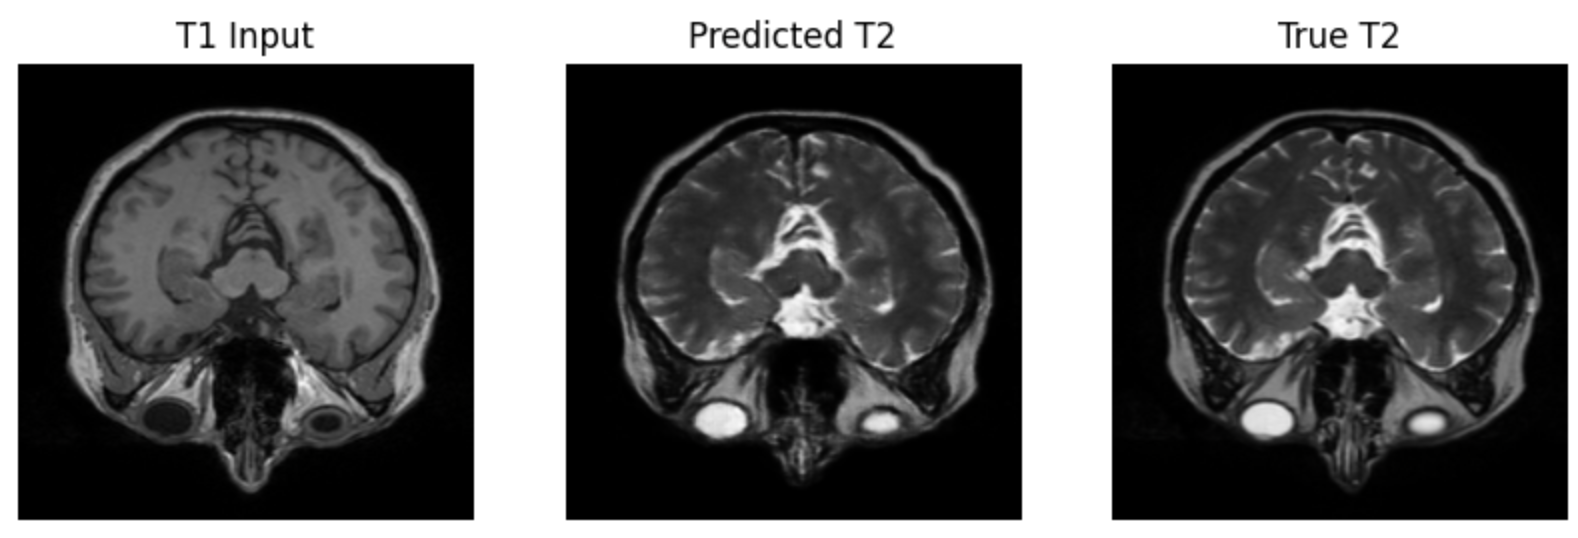

**Quantitative Outcomes of the Pix2Pix Model**

Our initial pix2pix model did not use cycleGAN harmonization and was able to generate the T2 scans with moderate accuracy. The average SSIM for the training data was 83%, and the average for the testing data was 62%.

Although our model does not achieve particularly high quantitative performance when evaluated using SSIM, the results are still encouraging when assessed qualitatively, as shown above. This highlights a known limitation of SSIM and similar performance metrics in medical imaging. Although SSIM looks for general structure similarity, it can still be penalized by small spatial shifts, slight blurring, or localized intensity differences. Even though these changes can go unnoticed to the human observer, they can cause the SSIM to greatly decrease.

Additionally, the model was trained on a limited subset of the available data (only 1 slice per patient was used) due to computational constraints, which likely restricted its ability to fully capture the variability present across subjects and sites. Given these limitations, the visual accuracy of the synthesized images indicates that the model’s performance is stronger than what SSIM alone suggests and could further improve with more training data and resources.


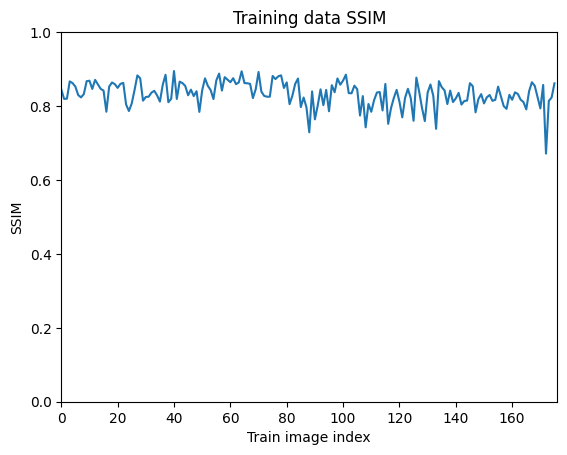

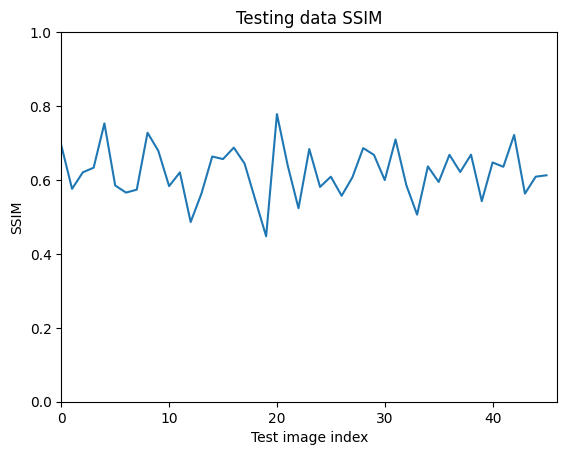


We further tested our results by training a ResNet18 model to predict which site a generated T2 image came from. Ideally, the trained ResNet18 model would fail at predicting the acquisition site of the generated T2 images because this indicates that the synthesis model has successfully removed site-specific information while preserving biologically meaningful anatomy. If a site classifier can accurately identify the source site from generated T2 images, it implies that scanner, protocol, or site-dependent biases are still encoded in the synthetic data, which undermines the goal of harmonization. In contrast, poor site prediction performance suggests that the generated images are invariant to site-related differences and instead reflect a shared, site-agnostic representation of tissue contrast. This is important for future analyses, as it reduces the risk that models trained on the synthesized images will learn site cues rather than true disease or anatomy related patterns, thereby improving generalization and fairness across multi-site datasets.

After training the ResNet18 model using the generated T2 scans, the model was able to predict which site the scans in our testing dataset came from with perfect accuracy. This indicates that further harmonization is needed in order to develop a general model that could work for a variety of sites.

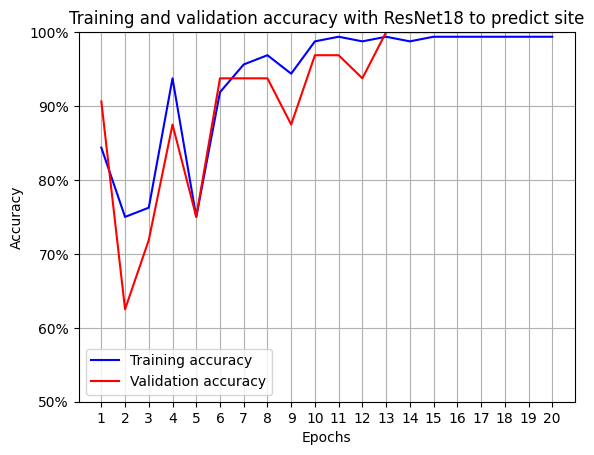

**CycleGAN Harmonization**

Two CycleGAN models were trained to learn mappings from Guys T1 to HH T1 and from Guys T2 to HH T2. Each model was trained using the respective training datasets and then applied to generate harmonized versions of both the training and testing data. The image below illustrates a representative T2 scan before and after harmonization. As shown, the harmonized image exhibits subtle changes, including slight streaking artifacts and marginally darker intensity values. Although these differences are barely perceptible to the human eye, they can substantially influence how the downstream pix2pix model processes data originating from different imaging sites.

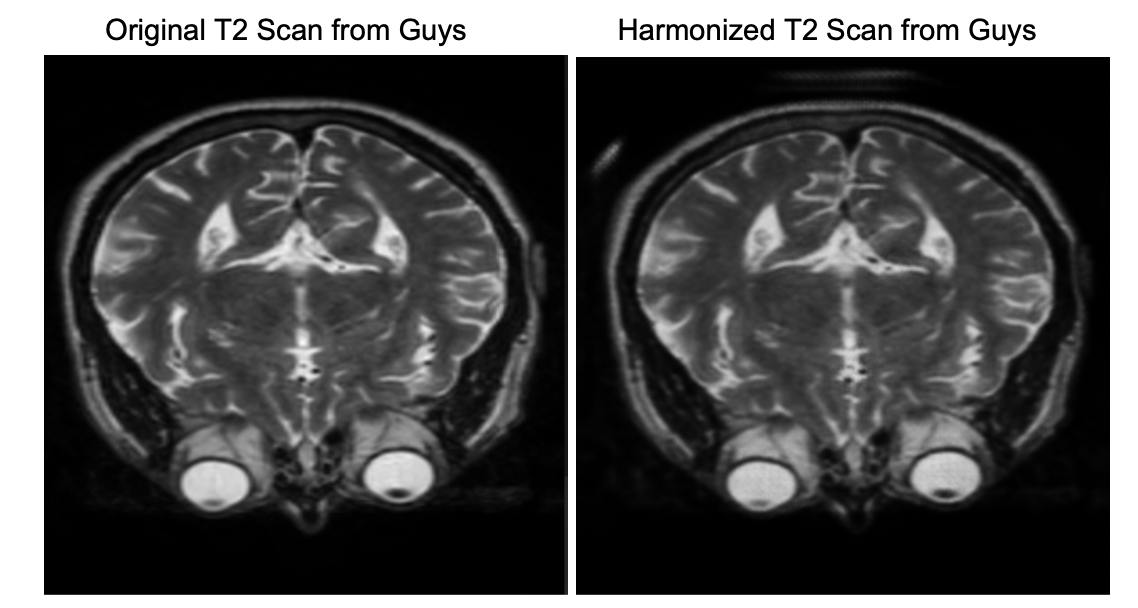

**Effects of Harmonization**

After retraining pix2pix on CycleGAN-harmonized data, the training and testing accuracy remained the same (82% SSIM for training data, 62% SSIM for testing data), which suggests that harmonization did not degrade the underlying T1→T2 mapping. Because both domains were transformed consistently, the model was still able to learn the same anatomical and contrast relationships as before. This stability indicates that harmonization acted as a domain-alignment step rather than introducing distortions that made the synthesis task harder.

The ResNet18 model was retrained to predict the acquisition site from the harmonized scans. After harmonization, the model achieved a test accuracy of approximately 78%, as shown below. This reduction in site-prediction performance indicates that harmonization was partially successful, as it became more difficult for the classifier to distinguish between sites. Consequently, this suggests that site-specific features were attenuated in the harmonized images, and that the pix2pix model was less likely to rely on site-related artifacts when generating T2 images and instead learned mappings driven primarily by underlying biological structure.



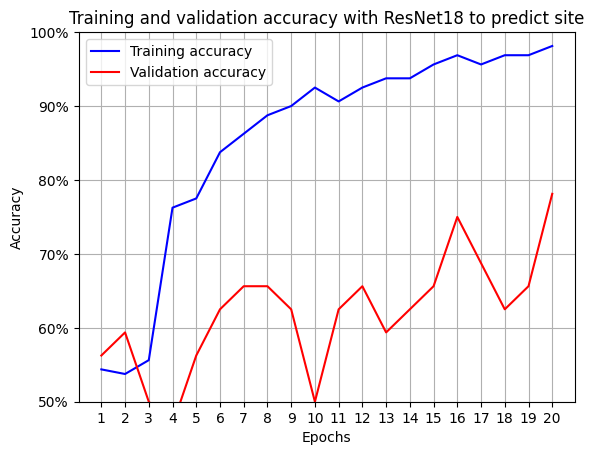

**Interperative Insights**

Overall, the results demonstrate that the pix2pix model is capable of generating realistic T2-weighted images from corresponding T1-weighted scans. When training on datasets collected across multiple acquisition sites, harmonization is an important preprocessing step to reduce site-specific bias and encourage the model to learn biologically meaningful mappings rather than relying on scanner-related artifacts. While the synthetic T2 images were visually very similar to the true T2 images, expert evaluation by a medical professional is necessary to determine whether clinically relevant biological features are faithfully preserved and remain suitable for diagnostic interpretation.

# **6. Conclusions**

**Project Overview**

This project explored how generative models can be used to produce synthetic T2-weighted MRI images from T1 scans, with a particular focus on how scanner differences influence performance. By combining image preprocessing, statistical harmonization, and GAN-based learning, we were able to compare models trained on original data to models trained on harmonized data. The results show that both pix2pix and CycleGAN contribute meaningful improvements to the image synthesis process.


**Summary of Findings**

Pix2pix successfully learned to generate T2-like images that preserved major anatomical features. However, scanner differences introduced inconsistencies that impacted prediction quality. After applying CycleGAN harmonization to reduce these differences, the retrained pix2pix model produced more consistent results betweens sites, suggesting that harmonization is a necessary step when working with multi-site MRI data.

**Broader Implications**

Based on qualitative analysis, the synthetic T2 images produced indicate promising results for determining if synthetic T2 images can be reliable enough for clinical use. However, because the model's accuracy was only around 62%, the model must be further developed to ensure that the synthetic images are accurate enough to make a medical diagnosis. Different performance metrics or more training data/computational resources should be utilized to further understand the model's capabilities before deciding whether synthetic T2 images can be used.

This project offers favorable insights for certain demographics of the population. Some groups, like children or individuals who need sedation, benefit from shortened scan times because it could reduce the need for anesthesia and lower healthcare costs. Although further analysis is needed, these potential benefits show how machine learning models like the ones explored in this project could support both clinical and operational improvements.

**Future Directions**

Although the current models show strong potential, there are several directions for future work. Training a 3D model could improve consistency across slices and capture more anatomical detail. Using full scan volumes instead of just mid-slices would also give the model more information to learn from. Incorporating quantitative metrics beyond SSIM, like Peak Signal-to-Noise Ratio (PSNR), would provide a more precise measure of performance. Testing the model on scans with real pathologies would also be essential before considering clinical applications, as not every scan will be of a healthy patient as was in this dataset.

# **7. Source Code**

Link to GitHub repository: https://github.com/ezeiberg33/spinSynthFinal



# **References**

[1] Sklar, S. (2025, February 18). How long does an MRI take? Understanding the process. Charlotte Radiology. https://www.charlotteradiology.com/blog/how-long-does-an-mri-take/

[2] Kawahara, D., & Nagata, Y. (2021). T1-weighted and T2-weighted MRI image synthesis with convolutional generative adversarial networks. Reports of Practical Oncology & Radiotherapy, 26(1), 35–42. https://doi.org/10.5603/rpor.a2021.0005

[3] MRI Basics. (n.d.). https://case.edu/med/neurology/NR/MRI%20Basics.htm

[4] Hayatghaibi, S. E., Cazaban, C. G., Chan, S. S., Dillman, J. R., Du, X. L.,Huang, Y., Mikhail, O. I., & Swint, J. M. (2022). Pediatric Outpatient Noncontrast Brain MRI: a Time-Driven Activity-Based costing analysis at three U.S. hospitals. American Journal of Roentgenology, 220(5), 747–756. https://doi.org/10.2214/ajr.22.28490

[5] Imperial College London. (n.d.). IXI [Dataset]. https://brain-development.org/ixi-dataset/

[6] Neuroimaging in Python — NiBabel 5.4.0.dev1+g3b1c7b37 documentation. (n.d.). https://nipy.org/nibabel/coordinate_systems.html

[7] Pluim, J., Woods, R., Viola and Wells, UW Medical Center, Mattes, D., & Haynor, D. (n.d.). Mutual Information Based Registration of Medical Images [Slide show]. https://courses.cs.washington.edu/courses/cse577/11au/notes/Z5-Mutual-Information.pdf

[8] ComBAT Harmonization for diffusion MRI: Challenges and Best Practices. (n.d.). https://arxiv.org/abs/2505.14722.

[9] Overview of GAN structure. (n.d.). Google for Developers. https://developers.google.com/machine-learning/gan/gan_structure

[10] Isola, P., Zhu, J., Zhou, T., & Efros, A. A. (2016, November 21). Image-to-Image Translation with Conditional Adversarial Networks. arXiv.org. https://arxiv.org/abs/1611.07004

[11] Zhu, J., Park, T., Isola, P., & Efros, A. A. (2017, March 30). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. arXiv.org. https://arxiv.org/abs/1703.10593

[12] Ronneberger, O., Fischer, P., & Brox, T. (2015, May 18). U-NET: Convolutional Networks for Biomedical Image Segmentation. arXiv.org. https://arxiv.org/abs/1505.04597

[13] Sahil. (2020, May 28). Understanding PatchGAN. Medium. Retrieved October 31, 2025, from https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207

[14] Nilsson, J., & Akenine-Möller, T. (2020, June 24). Understanding SSIM. arXiv.org. https://arxiv.org/abs/2006.13846


In [ ]:
# @title
